In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from datetime import timedelta

In [2]:
customers = pd.read_csv('DATA\\customers.csv')
geolocation = pd.read_csv('DATA\\geolocation.csv')
order_payments = pd.read_csv('DATA\\order_payments.csv')
order_reviews = pd.read_csv('DATA\\order_reviews.csv')
orders = pd.read_csv('DATA\\orders.csv')
orders_items = pd.read_csv('DATA\\orders_items.csv')
product_category_name_translation = pd.read_csv('DATA\\product_category_name_translation.csv')
products = pd.read_csv('DATA\\products.csv')
sellers = pd.read_csv('DATA\\sellers.csv') 

# Данные для обработки

In [3]:
dataset = (
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    pd.merge(
                            orders,
                            orders_items,
                            on='order_id'
                            ),
                        products,
                        on='product_id',
                        how='inner'
                        ),
                    product_category_name_translation,
                    on='product_category_name',
                    how='inner'
                    ),
                order_reviews, 
                on='order_id',
                how='inner'
                ),
            customers,
            on='customer_id',
            how='inner'
            )
)

#Рассматриваем только доставленные заказы
dataset = dataset[dataset['order_status'] == 'delivered']

#Количество проданных товаров всех категорий
dataset = pd.merge(
    dataset,
    dataset.groupby('seller_id')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'total_orders_per_seller'}),
    on='seller_id',
    how='left'
)

#Статистика продаж товаров по категориям и средняя оценка магазина
dataset = pd.merge(
    dataset,
    dataset.groupby(['product_category_name_english', 'seller_id'])
    .agg(
        total_items_sold_by_category=('order_id', 'count'),
        avg_seller_review_score=('review_score', 'mean'))
    .reset_index()
    .rename(columns={'avg_review_score': 'avg_review_score'}),
    on=['product_category_name_english', 'seller_id'],
    how='left'
)

dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['review_score']
           .mean()
           .reset_index()
           .rename(columns={'review_score': 'avg_review_score_by_customer'}),
    on='customer_unique_id',
    how='left'
)

# На случай, если средняя оценка в seller_stats вносит ошибку
# customer_avg_review_score = (
#     dataset.groupby('customer_unique_id')['avg_review_score']
#     .mean()
#     .reset_index()
#     .rename(columns={'avg_review_score': 'avg_review_score_unique'})
# )

# dataset = pd.merge(
#     dataset,
#     customer_avg_review_score,
#     on='customer_unique_id',
#     how='left'
# )

#Характеристики: Количество купленых категорий у конкретного магазина и по всему маркетплейсу
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['product_category_name_english']
    .count()
    .reset_index()
    .rename(columns={'product_category_name_english': 'customer_bying_prudocts_overoll'}),
    on='customer_unique_id',
    how='left'
)

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'product_category_name_english'])['seller_id']
    .count()
    .reset_index()
    .rename(columns={'seller_id': 'customer_bying_prudocts_by_seller'}),
    on=['customer_unique_id', 'product_category_name_english'],
    how='left'
)

#Перевод данных в формат даты
dataset['order_purchase_month'] = pd.to_datetime(dataset['order_purchase_timestamp']).dt.to_period('M')

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'order_purchase_month'])['order_id']
    .count()
    .reset_index(name='monthly_orders'),
    on='customer_unique_id',
    how='left'
)

#Количество всех предметов покупок на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_item_id']
           .count()
           .reset_index()
           .rename(columns={'order_item_id': 'total_items_bought'}),
    on='customer_unique_id',
    how='left'
)

#Количество заказов на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_id']
    .nunique()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'}),
    on='customer_unique_id',
    how='left'
)

In [4]:
dataset['customer_city']

0                       sao paulo
1                       sao paulo
2                       barreiras
3                      vianopolis
4         sao goncalo do amarante
                   ...           
113564               praia grande
113565                nova vicosa
113566                    japuiba
113567                    japuiba
113568                       lapa
Name: customer_city, Length: 113569, dtype: object

# Кластеризация покупателей

In [5]:
dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])
current_date = dataset['order_purchase_timestamp'].max()
deduplicates = dataset.drop_duplicates(subset=['customer_unique_id', 'order_id'])


deduplicates['recent_flag'] = deduplicates['order_purchase_timestamp'].apply(
    lambda x: 1 if (current_date - x).days <= 60 else 0
)

customer_data = deduplicates.groupby('customer_unique_id').agg(
    total_purchases=('order_id', 'nunique'),
    last_2_months_purchases=('recent_flag', 'sum')
).reset_index()

customer_data['customer_segment'] = 0

customer_data.loc[
    (customer_data['last_2_months_purchases'] > 1) & (customer_data['total_purchases'] > 1),
    'customer_segment'
] = 1  # Активные

customer_data.loc[
    (customer_data['last_2_months_purchases'] == 1) & (customer_data['total_purchases'] == 1),
    'customer_segment'
] = 1  # Новые

customer_data.loc[
    (customer_data['last_2_months_purchases'] == 1) & (customer_data['total_purchases'] > 2),
    'customer_segment'
] = 1  # Потенциально уйдут

customer_data.loc[
    (customer_data['last_2_months_purchases'] == 0) & (customer_data['total_purchases'] > 1),
    'customer_segment'
] = 2  # Ушедшие активные

customer_data.loc[
    (customer_data['last_2_months_purchases'] == 0) & (customer_data['total_purchases'] == 1),
    'customer_segment'
] = 2  # Ушедшие неактивные

# client_info = dataset[['customer_unique_id', 'customer_city', 'customer_state']].drop_duplicates()
# customer_data = customer_data.merge(client_info, on='customer_unique_id', how='left')

# city_mean_score = customer_data.groupby('customer_city')['customer_segment'].mean()
# state_mean_score = customer_data.groupby('customer_state')['customer_segment'].mean()
# product_category_name_score = dataset.groupby('product_category_name_english')['customer_segment'].mean()

# customer_data['city_encoded'] = customer_data['customer_city'].map(city_mean_score)
# customer_data['state_encoded'] = customer_data['customer_state'].map(state_mean_score)
# dataset['product_encoded'] = dataset['product_category_name_english'].map(product_category_name_score)

# customer_data.drop(['total_purchases'], axis=1)
# dataset = dataset.merge(customer_data, on='customer_unique_id', how='left')

C:\Users\s_mozhogin\AppData\Local\Temp\ipykernel_17476\4117358691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deduplicates['recent_flag'] = deduplicates['order_purchase_timestamp'].apply(


In [6]:
print(len(customer_data[customer_data['customer_segment'] == 0]))
print(len(customer_data[customer_data['customer_segment'] == 1]))
print(len(customer_data[customer_data['customer_segment'] == 2]))

238
12198
79046


In [7]:
dataset_drop = dataset.drop([
'order_status', 'order_item_id', 'review_score', 'product_id', 'seller_id',  'customer_id', 'review_id',
'price_2', 'freight_value_3',  'id_y',  'id_x', 'order_purchase_month_x', 'order_purchase_month_y',  'shipping_limit_date_1',
'customer_zip_code_prefix',
#'customer_city', 'customer_state',
'total_orders_per_seller', 'total_items_sold_by_category', 
'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'review_answer_timestamp',
'shipping_limit_date', 'product_category_name', 'review_comment_title', 'review_comment_message',
], axis=1)

In [8]:
dataset_drop[dataset_drop['customer_unique_id'] == 'ba77e9b6-5066-36dc-bd03-e463d4786f24'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 284 to 110152
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           8 non-null      object        
 1   order_purchase_timestamp           8 non-null      datetime64[ns]
 2   price                              8 non-null      float64       
 3   freight_value                      8 non-null      float64       
 4   product_category_name_english      8 non-null      object        
 5   review_creation_date               8 non-null      object        
 6   customer_unique_id                 8 non-null      object        
 7   customer_city                      8 non-null      object        
 8   customer_state                     8 non-null      object        
 9   avg_seller_review_score            8 non-null      float64       
 10  avg_review_score_by_customer       8 non

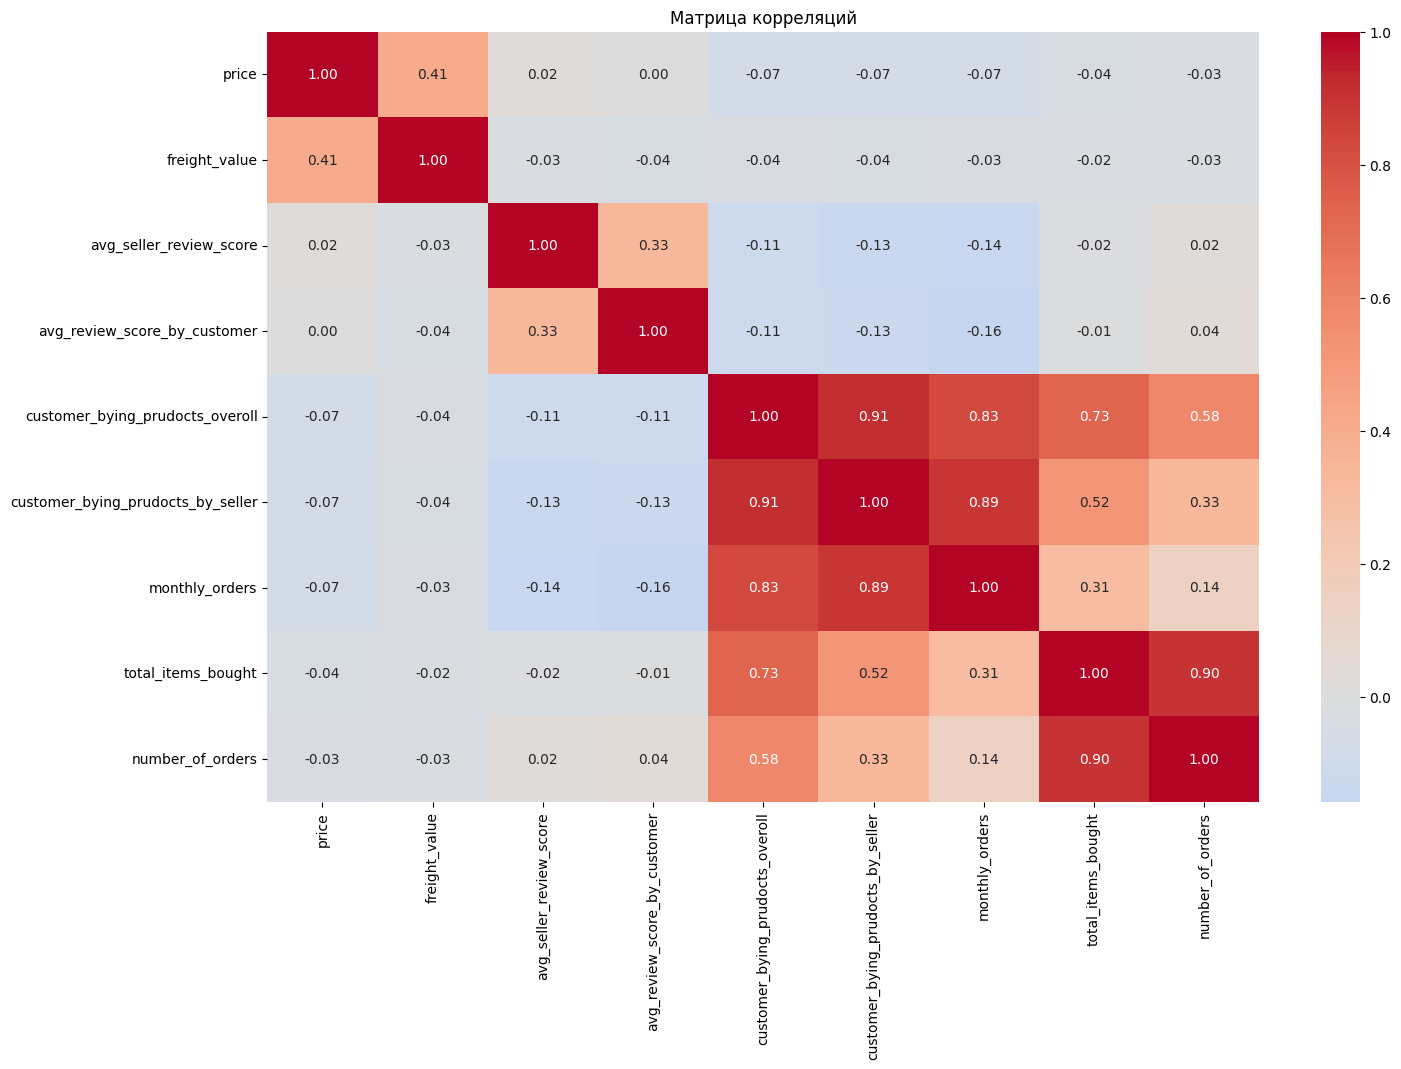

In [9]:
corr_matrix = dataset_drop.corr(numeric_only = True)


plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций")
plt.show()

In [10]:
# city_mean_score = dataset.groupby('customer_city')['customer_segment'].mean()
# state_mean_score = dataset.groupby('customer_state')['customer_segment'].mean()
# product_category_name_score = dataset.groupby('product_category_name_english')['customer_segment'].mean()

# customer_data['city_encoded'] = customer_data['customer_city'].map(city_mean_score)
# customer_data['state_encoded'] = customer_data['customer_state'].map(state_mean_score)
# dataset['product_encoded'] = dataset['product_category_name_english'].map(product_category_name_score)

In [11]:
# features_classification = dataset[[
#     'customer_unique_id',
#     'customer_segment',
#     'avg_review_score_by_customer',
#     'total_purchases',
#     'state_encoded',
#     'product_encoded',
#     'city_encoded'
# ]]

# Обучение модельки churm period

In [12]:
dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])
max_date = dataset['order_purchase_timestamp'].max()
print("Максимальная дата в данных:", max_date)

Максимальная дата в данных: 2018-08-29 15:00:37


In [13]:
cut_off_date = max_date - timedelta(days=60)

observation_window = 60

In [14]:
print("Кол-во клиентов до cut-off:", dataset[dataset['order_purchase_timestamp'] < cut_off_date]['customer_unique_id'].nunique())

Кол-во клиентов до cut-off: 79452


In [15]:
future_clients = dataset[
    (dataset['order_purchase_timestamp'] >= cut_off_date) &
    (dataset['order_purchase_timestamp'] < cut_off_date + timedelta(days=60))
]['customer_unique_id'].nunique()

print("Клиентов, сделавших покупки после cut-off:", future_clients)


Клиентов, сделавших покупки после cut-off: 12302


In [16]:
dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])

# Прошлые заказы
past_orders = dataset[dataset['order_purchase_timestamp'] < cut_off_date].copy()

# Заказы в "будущем" окне (для определения churn-а)
future_orders = dataset[
    (dataset['order_purchase_timestamp'] >= cut_off_date) &
    (dataset['order_purchase_timestamp'] < cut_off_date + timedelta(days=observation_window))
]

dedup = past_orders.drop_duplicates(subset=['customer_unique_id', 'order_id'])

# Дата последней покупки
last_purchase = dedup.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase.columns = ['customer_unique_id', 'last_purchase_date']

# Кол-во заказов
purchase_count = dedup.groupby('customer_unique_id')['order_id'].nunique().reset_index()
purchase_count.columns = ['customer_unique_id', 'total_purchases']

# Покупки в последние 60 дней до cut-off
recent_flag = dedup.copy()
recent_flag['recent_flag'] = (cut_off_date - recent_flag['order_purchase_timestamp']).dt.days <= observation_window
recent_purchases = recent_flag.groupby('customer_unique_id')['recent_flag'].sum().reset_index()
recent_purchases.columns = ['customer_unique_id', 'last_2_months_purchases']

# География
geo_info = past_orders[['customer_unique_id', 'customer_city', 'customer_state', 'product_category_name_english',
'avg_review_score_by_customer', 'avg_seller_review_score', 'review_score',
'monthly_orders', 'number_of_orders', 'customer_bying_prudocts_overoll', 'customer_bying_prudocts_by_seller', 'total_items_bought'
]].drop_duplicates()


In [17]:
past_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,id_x,order_item_id,...,total_items_sold_by_category,avg_seller_review_score,avg_review_score_by_customer,customer_bying_prudocts_overoll,customer_bying_prudocts_by_seller,order_purchase_month_x,order_purchase_month_y,monthly_orders,total_items_bought,number_of_orders
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,100785,1,...,7,3.714286,4.5,2,1,2017-10,2017-09,1,4,2
1,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,100785,1,...,7,3.714286,4.5,2,1,2017-10,2017-10,1,4,2
4,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,65021,1,...,154,4.474026,5.0,1,1,2017-11,2017-11,1,1,1
5,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,76043,1,...,130,3.800000,5.0,1,1,2018-02,2018-02,1,1,1
6,a4591c26-5e18-cb1d-cee5-2889e2d8acc3,503740e9-ca75-1ccd-da7b-a28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,72040,1,...,432,4.266204,4.0,1,1,2017-07,2017-07,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113564,63943bdd-c261-676b-46f0-1ca7ac2f7bd8,1fca14ff-2861-355f-6e5f-14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,43826,1,...,76,4.105263,4.0,1,1,2018-02,2018-02,1,1,1
113565,83c1379a-015d-f1e1-3d02-aae0204711ab,1aa71eb0-4212-1263-aafb-e80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,57884,1,...,6,4.000000,5.0,1,1,2017-08,2017-08,1,1,1
113566,11c177c8-e977-25db-2631-073c19f07b62,b331b74b-18dc-79bc-df65-32d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,7844,1,...,330,4.284848,2.0,2,2,2018-01,2018-01,2,2,1
113567,11c177c8-e977-25db-2631-073c19f07b62,b331b74b-18dc-79bc-df65-32d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,7845,2,...,330,4.284848,2.0,2,2,2018-01,2018-01,2,2,1


In [18]:
# Объединение всех фичей
customer_features = last_purchase.merge(purchase_count, on='customer_unique_id', how='left') \
                                 .merge(recent_purchases, on='customer_unique_id', how='left') \
                                 .merge(geo_info, on='customer_unique_id', how='left')
                                 


# Заполним пропуски, если есть
customer_features['last_2_months_purchases'] = customer_features['last_2_months_purchases'].fillna(0)

# Клиенты, у которых была покупка в будущем окне
future_customers = future_orders['customer_unique_id'].unique()
customer_features['inactive_flag'] = ~customer_features['customer_unique_id'].isin(future_customers)
customer_features['inactive_flag'] = customer_features['inactive_flag'].astype(int)


city_score = customer_features.groupby('customer_city')['inactive_flag'].mean()
state_score = customer_features.groupby('customer_state')['inactive_flag'].mean()
product_category_name_score = customer_features.groupby('product_category_name_english')['inactive_flag'].mean()

customer_features['city_encoded'] = customer_features['customer_city'].map(city_score)
customer_features['state_encoded'] = customer_features['customer_state'].map(state_score)
customer_features['product_encoded'] = dataset['product_category_name_english'].map(product_category_name_score)

X = customer_features[['total_purchases', 'city_encoded', 'total_items_bought', 'product_encoded'


#'total_purchases', 'last_2_months_purchases', 'city_encoded', 'state_encoded', 'product_encoded', 'avg_review_score_by_customer',
#'total_items_bought', 'customer_bying_prudocts_by_seller', 'customer_bying_prudocts_overoll', 'number_of_orders', 'review_score', 'monthly_orders', 'avg_seller_review_score'
]]
y = customer_features['inactive_flag']

In [19]:
print(customer_features.columns.tolist())

['customer_unique_id', 'last_purchase_date', 'total_purchases', 'last_2_months_purchases', 'customer_city', 'customer_state', 'product_category_name_english', 'avg_review_score_by_customer', 'avg_seller_review_score', 'review_score', 'monthly_orders', 'number_of_orders', 'customer_bying_prudocts_overoll', 'customer_bying_prudocts_by_seller', 'total_items_bought', 'inactive_flag', 'city_encoded', 'state_encoded', 'product_encoded']


# Модель

In [20]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score

In [21]:
X = X.fillna(0)  # если вдруг где-то есть пропуски

# Разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Расчёт веса для положительного класса

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum(),  # компенсация дисбаланса
    random_state=42
)
model.fit(X_train, y_train)

C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Преобразуем X_train и y_train в numpy массивы (если они не таковы)
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# Рассчитаем scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Определим модель
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Важный параметр для дисбалансированных данных
    use_label_encoder=False,
    random_state=42
)

# Кросс-валидация с StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 фолдов

accuracies = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Обучаем модель на текущем фолде
    model.fit(X_train_fold, y_train_fold)
    
    # Прогнозируем на валидационном наборе
    y_pred = model.predict(X_val_fold)
    
    # Рассчитываем точность
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

# Выводим среднюю точность по всем фолдам
print(f"Средняя точность: {np.mean(accuracies):.4f}")


C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Средняя точность: 0.9884


C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.44        85
           1       1.00      0.99      0.99     16701

    accuracy                           0.99     16786
   macro avg       0.64      0.99      0.72     16786
weighted avg       1.00      0.99      0.99     16786

AUC-ROC: 0.9970586474216057


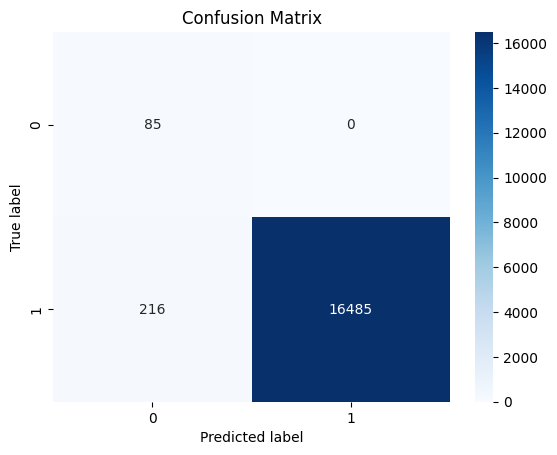

In [23]:
# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

# Метрики
print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [24]:
# Предсказания модели
y_pred = model.predict(X_test)

# Создадим датафрейм с результатами
results = X_test.copy()
results['predicted_inactive_flag'] = y_pred
results['actual_inactive_flag'] = y_test.values

# Добавим customer_unique_id (нужно подтянуть из customer_features)
results = results.merge(customer_features[['customer_unique_id']], left_index=True, right_index=True)

# Посмотрим, кого модель считает активным (inactive_flag == 0)
predicted_active_customers = results[results['predicted_inactive_flag'] == 0]

# # И наоборот — предсказанные неактивные
predicted_inactive_customers = results[results['predicted_inactive_flag'] == 1]

# results.to_csv('predictions_1.csv', index=False)

print(results.columns.tolist())

['total_purchases', 'city_encoded', 'total_items_bought', 'product_encoded', 'predicted_inactive_flag', 'actual_inactive_flag', 'customer_unique_id']


In [25]:
results_drop = results.drop(['total_purchases', 'city_encoded', 'total_items_bought', 'product_encoded', 'actual_inactive_flag'], axis=1)

results_drop.to_csv('predictions.csv', index = False)


In [26]:
# Предсказания модели
y_pred = model.predict(X_test)

# Создадим датафрейм с только нужными колонками
results = pd.DataFrame({
    'customer_unique_id': X_test.index,
    'predicted_inactive_flag': y_pred
})

# Если нужно добавить столбец с реальными значениями (для проверки)
results['actual_inactive_flag'] = y_test.values

# Теперь у нас есть только customer_unique_id и predicted_inactive_flag
print(results[results['predicted_inactive_flag'] == 0])

# results.to_csv('predictions_2.csv', index=False)

       customer_unique_id  predicted_inactive_flag  actual_inactive_flag
7                   20476                        0                     1
102                 58727                        0                     1
137                 54901                        0                     0
160                 50993                        0                     0
237                 42025                        0                     1
...                   ...                      ...                   ...
16642               11269                        0                     1
16680               68726                        0                     1
16685               65168                        0                     0
16698               39487                        0                     1
16722               81582                        0                     0

[301 rows x 3 columns]


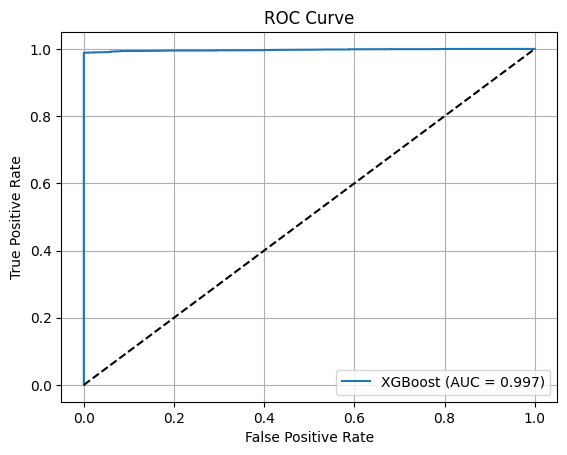

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.3f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')  # линия случайных предсказаний
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


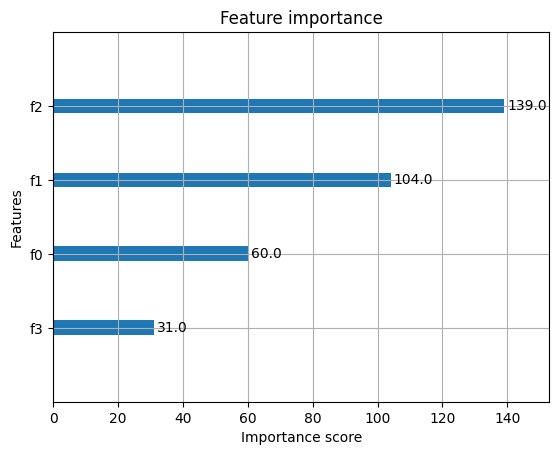

In [28]:
xgb.plot_importance(model, max_num_features=10)
plt.show()

## Модель с oversampling

In [29]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

In [30]:
X = X.fillna(0)  # если вдруг где-то есть пропуски

# Разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Расчёт веса для положительного класса

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum(),  # компенсация дисбаланса
    random_state=42
)

model.fit(X_train, y_train)

C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16700
           1       1.00      1.00      1.00     16700

    accuracy                           1.00     33400
   macro avg       1.00      1.00      1.00     33400
weighted avg       1.00      1.00      1.00     33400

AUC-ROC: 0.9998456972282979


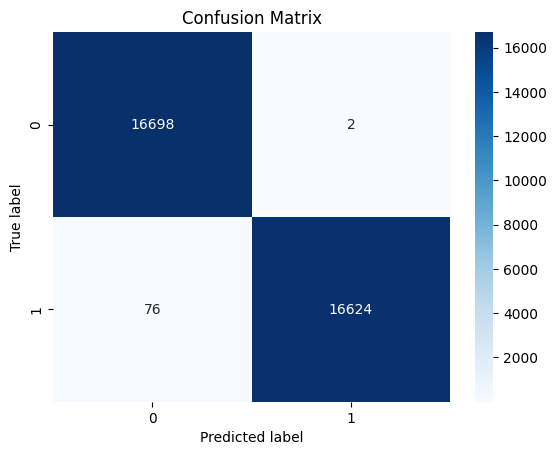

In [31]:
# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

# Метрики
print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [32]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

C:\mipt\lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13360
           1       1.00      1.00      1.00     13360

    accuracy                           1.00     26720
   macro avg       1.00      1.00      1.00     26720
weighted avg       1.00      1.00      1.00     26720

AUC-ROC: 0.9998000107569293


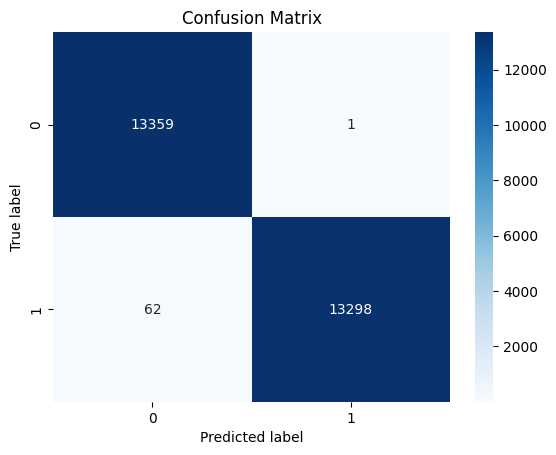

In [33]:
X = X.fillna(0)  # если вдруг где-то есть пропуски

# Разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Расчёт веса для положительного класса

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum(),  # компенсация дисбаланса
    random_state=42
)

model.fit(X_train, y_train)
# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

# Метрики
print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
